### **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# Mengabaikan warning yang sering muncul dari statsmodels untuk data kecil
warnings.filterwarnings("ignore")

### **2. Import Data Hasil Rules**

In [2]:
df = pd.read_csv('data/rules2024.csv')
df.head()

,Unnamed: 0,antecedents,consequents,support,confidence,lift
0,0,"frozenset({'SAKINAH 1500ML', 'GREENFIELDS COKL...",frozenset({'GREENFIELDS STRAW 105ML'}),0.000109,1,4922.846154
1,1,"frozenset({'BISKUAT BOLU CKL 16GR', 'INDOMILK ...","frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",0.000141,1,2206.793103
2,2,"frozenset({'GATSBY SPL/C GS 175ML', 'FRESHCARE...",frozenset({'GATSBY SPL/C DO 175ML'}),0.000141,1,1185.129630
3,3,"frozenset({'KISPRAY POUCH GLAM/GLD 300ML', 'IN...",frozenset({'SOKLIN LIQ LAVENDER 625ML'}),0.000109,1,831.129870
4,4,"frozenset({'SEDAAP MIE CUP BASO BLEDUK', 'SEDA...",frozenset({'SEDAAP MIE CUP SOTO'}),0.000125,1,780.451220


### **3. Ambil Top 3 Rules dengan Akurasi Tinggi**

In [3]:
df_top3 = df.head(3)
df_top3

,Unnamed: 0,antecedents,consequents,support,confidence,lift
0,0,"frozenset({'SAKINAH 1500ML', 'GREENFIELDS COKL...",frozenset({'GREENFIELDS STRAW 105ML'}),0.000109,1,4922.846154
1,1,"frozenset({'BISKUAT BOLU CKL 16GR', 'INDOMILK ...","frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",0.000141,1,2206.793103
2,2,"frozenset({'GATSBY SPL/C GS 175ML', 'FRESHCARE...",frozenset({'GATSBY SPL/C DO 175ML'}),0.000141,1,1185.129630


### **4. Ambil Item dari Top 3**

In [4]:
# Pastikan semua elemen dalam kolom antecedents dan consequents adalah frozenset
df_top3["antecedents"] = df_top3["antecedents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)
df_top3["consequents"] = df_top3["consequents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)

# Mengambil semua item unik
all_items = set()
for col in ["antecedents", "consequents"]:
    for items in df_top3[col]:
        all_items.update(items)

all_items

{'BISKUAT BOLU CKL 16GR',
 'CLOUD 9 CHOCO 15 4G',
 'CLOUD 9 VANILA 15 4G',
 'FRESHCARE ORIGINAL 10ML',
 'GATSBY SPL/C DO 175ML',
 'GATSBY SPL/C GS 175ML',
 'GREENFIELDS COKLAT 105ML',
 'GREENFIELDS STRAW 105ML',
 'INDOMILK KID CKL 115ML',
 'INDOMILK KID VNL 115ML',
 'SAKINAH 1500ML'}

### **5. Import Data Transaksi**

In [5]:
groceries = pd.read_excel('data/final_data2024.xlsx')
groceries

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
0,2024-01-01,2401011010001,GULA ROSE BRAND 1KG,1
1,2024-01-01,2401011010002,RIZKI MG 850ML/900ML BTL,3
2,2024-01-01,2401011010003,ULTRA MIMI VNL 125ML,1
3,2024-01-01,2401011010003,BEAR BRAND 189ML,1
4,2024-01-01,2401011010003,TINI WINI BITI ASIN 20 GR,1
...,...,...,...,...
167618,2024-12-31,2412311020122,WALLS POPULAIRE CKL,1
167619,2024-12-31,2412311020123,THERMAL 80X50 TRUST PAPER,1
167620,2024-12-31,2412311020124,SAKINAH 600ML,1
167621,2024-12-31,2412311020124,WALLS PP RAINBOW P,1


### **6. Filter Data Transaksi**

In [6]:
df_filtered = groceries[groceries['NAMA BARANG'].isin(all_items)]
df_filtered 

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
59,2024-01-01,2401011010018,INDOMILK KID VNL 115ML,1
1032,2024-01-02,2401021010091,BISKUAT BOLU CKL 16GR,2
1155,2024-01-03,2401031010006,INDOMILK KID VNL 115ML,3
1364,2024-01-03,2401031010077,SAKINAH 1500ML,1
2003,2024-01-04,2401041010044,SAKINAH 1500ML,1
...,...,...,...,...
167362,2024-12-31,2412311020034,INDOMILK KID CKL 115ML,1
167384,2024-12-31,2412311020038,INDOMILK KID CKL 115ML,1
167398,2024-12-31,2412311020042,SAKINAH 1500ML,1
167537,2024-12-31,2412311020090,INDOMILK KID CKL 115ML,1


In [7]:
# Menampilkan jumlah unik nama barang
jumlah_nama_barang = df_filtered['NAMA BARANG'].nunique()
print("Jumlah nama barang unik:", jumlah_nama_barang)

# Menampilkan isi nama barang yang unik
nama_barang_unik = df_filtered['NAMA BARANG'].unique()
print("Nama barang unik:")
for nama in nama_barang_unik:
    print("-", nama)

Jumlah nama barang unik: 11
Nama barang unik:
- INDOMILK KID VNL 115ML
- BISKUAT BOLU CKL 16GR
- SAKINAH 1500ML
- INDOMILK KID CKL 115ML
- GATSBY SPL/C DO 175ML
- GATSBY SPL/C GS 175ML
- FRESHCARE ORIGINAL 10ML
- CLOUD 9 VANILA 15 4G
- CLOUD 9 CHOCO 15 4G
- GREENFIELDS COKLAT 105ML
- GREENFIELDS STRAW 105ML


### **7. Agregasi Data Mingguan**

In [8]:
# Agregasi jumlah QTY per tanggal dan nama barang
df_grouped = df_filtered.groupby(['TANGGAL', 'NAMA BARANG'], as_index=False)['QTY'].sum()

tanggal_range = pd.date_range(start='2024-01-01', end='2024-12-31')
all_items = df_filtered['NAMA BARANG'].unique()

# Buat kombinasi semua tanggal dan item
multi_index = pd.MultiIndex.from_product([tanggal_range, all_items], names=['TANGGAL', 'NAMA BARANG'])
all_combinations = pd.DataFrame(index=multi_index).reset_index()

# Gabungkan dengan hasil groupby
df_joined = pd.merge(all_combinations, df_grouped, on=['TANGGAL', 'NAMA BARANG'], how='left')
df_joined['QTY'] = df_joined['QTY'].fillna(0)

# Pastikan TANGGAL dalam datetime
df_joined['TANGGAL'] = pd.to_datetime(df_joined['TANGGAL'])

# Urutkan dulu datanya
df_joined = df_joined.sort_values('TANGGAL')

# Ambil tanggal paling awal
start_date = df_joined['TANGGAL'].min()

# Hitung minggu ke-n secara manual (tiap 7 hari)
df_joined['WEEK_NUMBER'] = ((df_joined['TANGGAL'] - start_date).dt.days // 7) + 1

# Agregasi berdasarkan minggu dan nama barang
df_weekly = df_joined.groupby(['WEEK_NUMBER', 'NAMA BARANG'], as_index=False)['QTY'].sum()

# (Opsional) Tambahkan kolom tanggal mulai minggu
df_weekly['TANGGAL'] = start_date + pd.to_timedelta((df_weekly['WEEK_NUMBER'] - 1) * 7, unit='D')

# Visualisasi
fig = px.line(df_weekly, x='TANGGAL', y='QTY', color='NAMA BARANG',
              title='Jumlah Penjualan per Minggu (Setiap 7 Hari)')
fig.update_layout(legend_title_text='Klik untuk tampilkan/sembunyikan item')
fig.show()

In [9]:
df_weekly

,WEEK_NUMBER,NAMA BARANG,QTY,TANGGAL
0,1,BISKUAT BOLU CKL 16GR,5.0,2024-01-01
1,1,CLOUD 9 CHOCO 15 4G,3.0,2024-01-01
2,1,CLOUD 9 VANILA 15 4G,4.0,2024-01-01
3,1,FRESHCARE ORIGINAL 10ML,1.0,2024-01-01
4,1,GATSBY SPL/C DO 175ML,2.0,2024-01-01
...,...,...,...,...
578,53,GREENFIELDS COKLAT 105ML,0.0,2024-12-30
579,53,GREENFIELDS STRAW 105ML,0.0,2024-12-30
580,53,INDOMILK KID CKL 115ML,21.0,2024-12-30
581,53,INDOMILK KID VNL 115ML,6.0,2024-12-30


### **8. Pivot Data**

In [10]:
df_pivoted= df_weekly.pivot(index='TANGGAL', columns='NAMA BARANG', values='QTY')
df_pivoted.columns.name = None  # hilangkan nama kolom atas
df_pivoted = df_pivoted.reset_index() 
df_pivoted.head()

,TANGGAL,BISKUAT BOLU CKL 16GR,CLOUD 9 CHOCO 15 4G,CLOUD 9 VANILA 15 4G,FRESHCARE ORIGINAL 10ML,GATSBY SPL/C DO 175ML,GATSBY SPL/C GS 175ML,GREENFIELDS COKLAT 105ML,GREENFIELDS STRAW 105ML,INDOMILK KID CKL 115ML,INDOMILK KID VNL 115ML,SAKINAH 1500ML
0,2024-01-01,5.0,3.0,4.0,1.0,2.0,1.0,0.0,0.0,3.0,8.0,6.0
1,2024-01-08,4.0,7.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,13.0,6.0
2,2024-01-15,7.0,5.0,7.0,1.0,0.0,0.0,0.0,0.0,13.0,10.0,5.0
3,2024-01-22,5.0,5.0,7.0,0.0,2.0,0.0,0.0,0.0,18.0,14.0,8.0
4,2024-01-29,0.0,10.0,7.0,0.0,1.0,1.0,0.0,0.0,20.0,19.0,4.0


In [11]:
df_pivoted.head(3)

,TANGGAL,BISKUAT BOLU CKL 16GR,CLOUD 9 CHOCO 15 4G,CLOUD 9 VANILA 15 4G,FRESHCARE ORIGINAL 10ML,GATSBY SPL/C DO 175ML,GATSBY SPL/C GS 175ML,GREENFIELDS COKLAT 105ML,GREENFIELDS STRAW 105ML,INDOMILK KID CKL 115ML,INDOMILK KID VNL 115ML,SAKINAH 1500ML
0,2024-01-01,5.0,3.0,4.0,1.0,2.0,1.0,0.0,0.0,3.0,8.0,6.0
1,2024-01-08,4.0,7.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,13.0,6.0
2,2024-01-15,7.0,5.0,7.0,1.0,0.0,0.0,0.0,0.0,13.0,10.0,5.0


In [12]:
df_pivoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TANGGAL                   53 non-null     datetime64[ns]
 1   BISKUAT BOLU CKL 16GR     53 non-null     float64       
 2   CLOUD 9 CHOCO 15 4G       53 non-null     float64       
 3   CLOUD 9 VANILA 15 4G      53 non-null     float64       
 4   FRESHCARE ORIGINAL 10ML   53 non-null     float64       
 5   GATSBY SPL/C DO 175ML     53 non-null     float64       
 6   GATSBY SPL/C GS 175ML     53 non-null     float64       
 7   GREENFIELDS COKLAT 105ML  53 non-null     float64       
 8   GREENFIELDS STRAW 105ML   53 non-null     float64       
 9   INDOMILK KID CKL 115ML    53 non-null     float64       
 10  INDOMILK KID VNL 115ML    53 non-null     float64       
 11  SAKINAH 1500ML            53 non-null     float64       
dtypes: datetime64[ns](1), fl

In [13]:
# Mengubah kolom TANGGAL menjadi datetime dan menjadikannya index
df_pivoted['TANGGAL'] = pd.to_datetime(df_pivoted['TANGGAL'])
df_pivoted = df_pivoted.set_index('TANGGAL')
df_pivoted = df_pivoted.asfreq('W-MON') # Menetapkan frekuensi mingguan (Senin)

print("Data Anda:")
print(df_pivoted.head())
print("\nJumlah data per item:", len(df_pivoted))

Data Anda:
            BISKUAT BOLU CKL 16GR  CLOUD 9 CHOCO 15 4G  CLOUD 9 VANILA 15 4G  \
TANGGAL                                                                        
2024-01-01                    5.0                  3.0                   4.0   
2024-01-08                    4.0                  7.0                   1.0   
2024-01-15                    7.0                  5.0                   7.0   
2024-01-22                    5.0                  5.0                   7.0   
2024-01-29                    0.0                 10.0                   7.0   

            FRESHCARE ORIGINAL 10ML  GATSBY SPL/C DO 175ML  \
TANGGAL                                                      
2024-01-01                      1.0                    2.0   
2024-01-08                      0.0                    3.0   
2024-01-15                      1.0                    0.0   
2024-01-22                      0.0                    2.0   
2024-01-29                      0.0                    1

In [ ]:
# --- 2. Konfigurasi Forecasting ---
FORECAST_HORIZON = 4  # Berapa minggu ke depan Anda ingin memprediksi
TRAIN_RATIO = 0.8     # Rasio data yang akan digunakan untuk training (e.g., 0.8 = 80%)

# Dapatkan daftar nama item (kolom selain TANGGAL yang sudah jadi index)
item_columns = df_pivoted.columns.tolist()

# Dictionary untuk menyimpan hasil evaluasi dan prediksi
evaluation_results = {}
future_forecasts = pd.DataFrame(index=pd.date_range(start=df_pivoted.index[-1] + pd.Timedelta(weeks=1),
                                                    periods=FORECAST_HORIZON,
                                                    freq='W-MON'))

In [ ]:
# --- Fungsi untuk menghitung MAPE kustom ---
# Mengabaikan nilai aktual nol untuk menghindari pembagian dengan nol
def mean_absolute_percentage_error(y_true, y_pred):
    # Mengonversi ke numpy array untuk operasi yang lebih mudah
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Filter keluar nilai aktual yang nol untuk menghindari pembagian dengan nol
    non_zero_actuals = y_true != 0
    if not np.any(non_zero_actuals): # Jika tidak ada nilai aktual yang tidak nol
        return np.nan # Tidak dapat menghitung MAPE jika semua aktual adalah nol

    y_true_filtered = y_true[non_zero_actuals]
    y_pred_filtered = y_pred[non_zero_actuals]

    # Menghitung persentase error
    # Tambahkan epsilon kecil ke penyebut jika Anda ingin mencoba mencegah inf
    # Namun, untuk 0, lebih baik diabaikan seperti di atas.
    # Disini kita mengabaikan y_true = 0, jadi tidak perlu epsilon lagi.
    errors = np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)
    return np.mean(errors) * 100


--- Memulai Proses Forecasting dan Evaluasi ---

Memproses Item: BISKUAT BOLU CKL 16GR
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk BISKUAT BOLU CKL 16GR (periode evaluasi):
            Actual  Predicted
2024-10-21     5.0        4.0
2024-10-28     5.0        4.0
2024-11-04     8.0        4.0
2024-11-11     7.0        4.0
2024-11-18    13.0        4.0
2024-11-25     4.0        4.0
2024-12-02     3.0        4.0
2024-12-09     6.0        4.0
2024-12-16     5.0        4.0
2024-12-23     5.0        4.0
2024-12-30     0.0        4.0

  Evaluasi Model BISKUAT BOLU CKL 16GR:
  MAE (Mean Absolute Error): 2.45
  RMSE (Root Mean Squared Error): 3.45
  MAPE (Mean Absolute Percentage Error): 30.88%

  Prediksi Penjualan BISKUAT BOLU CKL 16GR untuk 4 minggu ke depan:
202

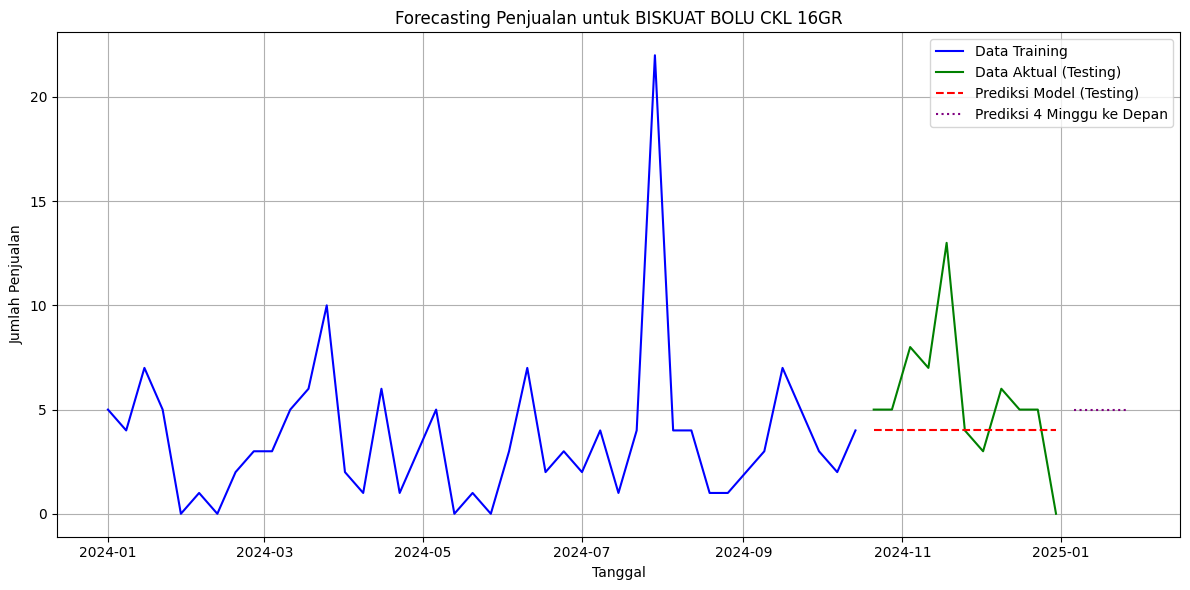



Memproses Item: CLOUD 9 CHOCO 15 4G
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk CLOUD 9 CHOCO 15 4G (periode evaluasi):
            Actual  Predicted
2024-10-21    17.0        5.0
2024-10-28     2.0        5.0
2024-11-04     9.0        5.0
2024-11-11     6.0        5.0
2024-11-18    13.0        5.0
2024-11-25     6.0        5.0
2024-12-02     0.0        5.0
2024-12-09     2.0        5.0
2024-12-16     0.0        5.0
2024-12-23     4.0        5.0
2024-12-30     5.0        5.0

  Evaluasi Model CLOUD 9 CHOCO 15 4G:
  MAE (Mean Absolute Error): 3.91
  RMSE (Root Mean Squared Error): 5.18
  MAPE (Mean Absolute Percentage Error): 59.43%

  Prediksi Penjualan CLOUD 9 CHOCO 15 4G untuk 4 minggu ke depan:
2025-01-06    5.0
2025-01-13    5.0
2025-01-20    5.0
2025-

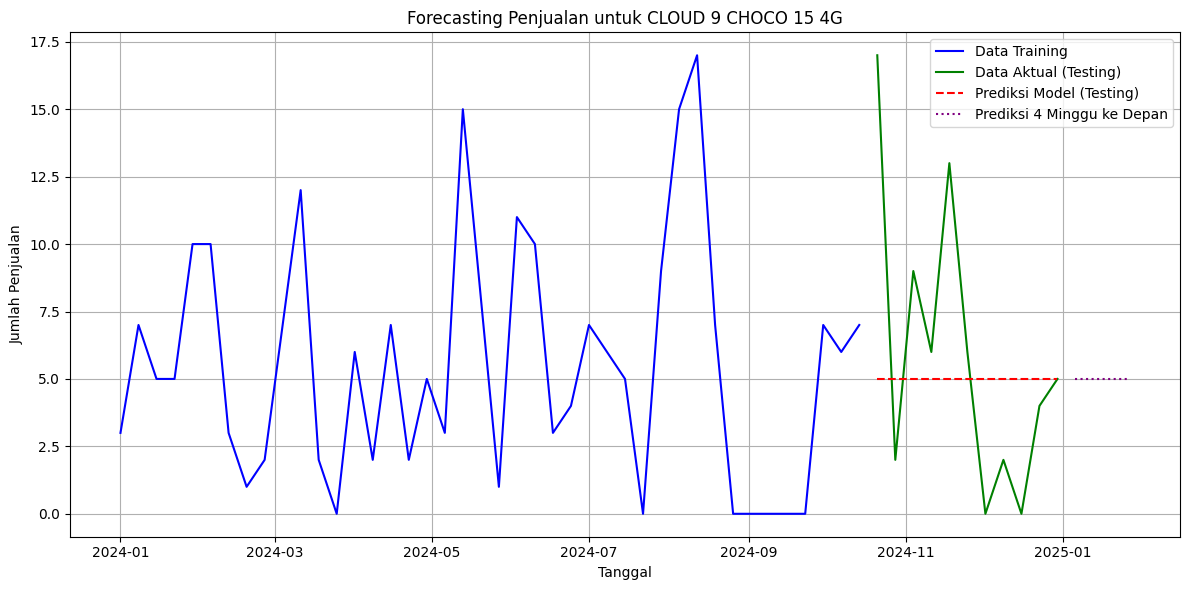



Memproses Item: CLOUD 9 VANILA 15 4G
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk CLOUD 9 VANILA 15 4G (periode evaluasi):
            Actual  Predicted
2024-10-21     5.0        2.0
2024-10-28     5.0        2.0
2024-11-04     4.0        2.0
2024-11-11     3.0        2.0
2024-11-18     7.0        2.0
2024-11-25     1.0        2.0
2024-12-02     6.0        1.0
2024-12-09     5.0        1.0
2024-12-16     1.0        1.0
2024-12-23     6.0        1.0
2024-12-30     6.0        1.0

  Evaluasi Model CLOUD 9 VANILA 15 4G:
  MAE (Mean Absolute Error): 3.09
  RMSE (Root Mean Squared Error): 3.57
  MAPE (Mean Absolute Percentage Error): 64.07%

  Prediksi Penjualan CLOUD 9 VANILA 15 4G untuk 4 minggu ke depan:
2025-01-06    5.0
2025-01-13    5.0
2025-01-20    5.0
2

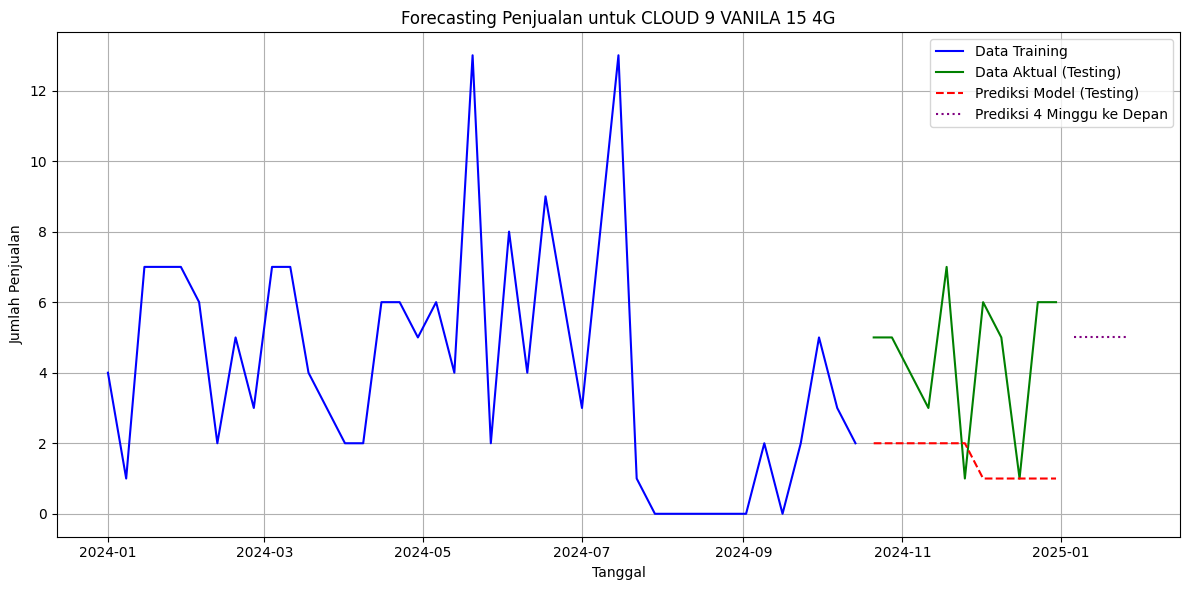



Memproses Item: FRESHCARE ORIGINAL 10ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk FRESHCARE ORIGINAL 10ML (periode evaluasi):
            Actual  Predicted
2024-10-21     2.0        1.0
2024-10-28     3.0        1.0
2024-11-04     0.0        1.0
2024-11-11     0.0        1.0
2024-11-18     2.0        1.0
2024-11-25     2.0        1.0
2024-12-02     0.0        1.0
2024-12-09     0.0        1.0
2024-12-16     1.0        1.0
2024-12-23     2.0        1.0
2024-12-30     0.0        1.0

  Evaluasi Model FRESHCARE ORIGINAL 10ML:
  MAE (Mean Absolute Error): 1.00
  RMSE (Root Mean Squared Error): 1.09
  MAPE (Mean Absolute Percentage Error): 44.44%

  Prediksi Penjualan FRESHCARE ORIGINAL 10ML untuk 4 minggu ke depan:
2025-01-06    1.0
2025-01-13    1.0
2025-01

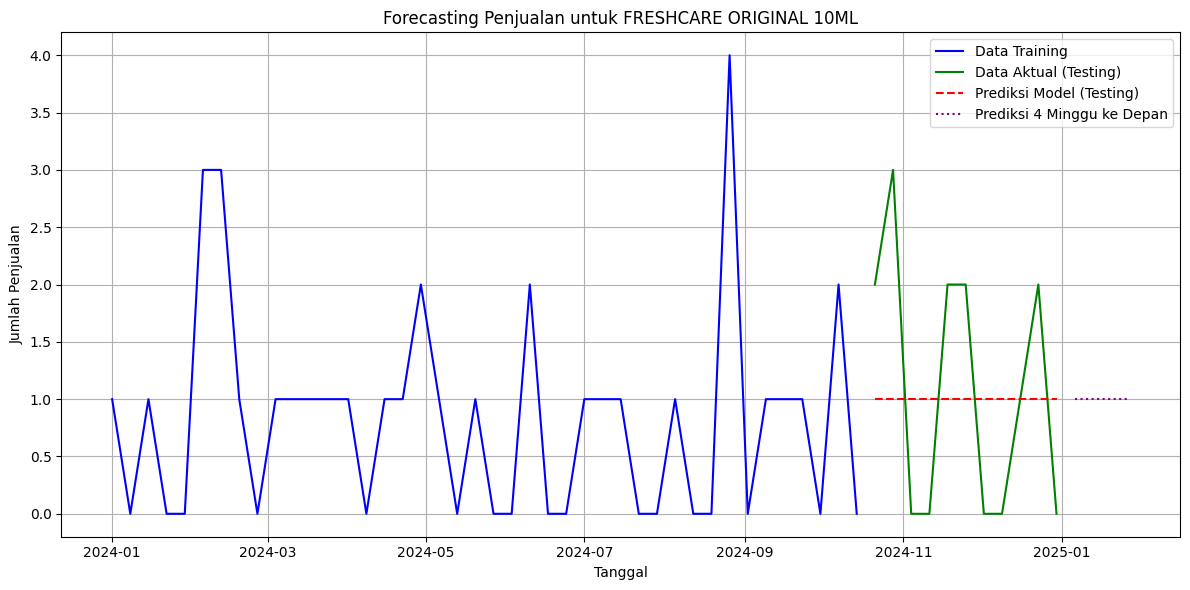



Memproses Item: GATSBY SPL/C DO 175ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk GATSBY SPL/C DO 175ML (periode evaluasi):
            Actual  Predicted
2024-10-21     1.0        1.0
2024-10-28     1.0        1.0
2024-11-04     1.0        1.0
2024-11-11     1.0        1.0
2024-11-18     0.0        1.0
2024-11-25     1.0        1.0
2024-12-02     0.0        1.0
2024-12-09     0.0        1.0
2024-12-16     2.0        1.0
2024-12-23     1.0        1.0
2024-12-30     0.0        1.0

  Evaluasi Model GATSBY SPL/C DO 175ML:
  MAE (Mean Absolute Error): 0.45
  RMSE (Root Mean Squared Error): 0.67
  MAPE (Mean Absolute Percentage Error): 7.14%

  Prediksi Penjualan GATSBY SPL/C DO 175ML untuk 4 minggu ke depan:
2025-01-06    1.0
2025-01-13    1.0
2025-01-20    1.

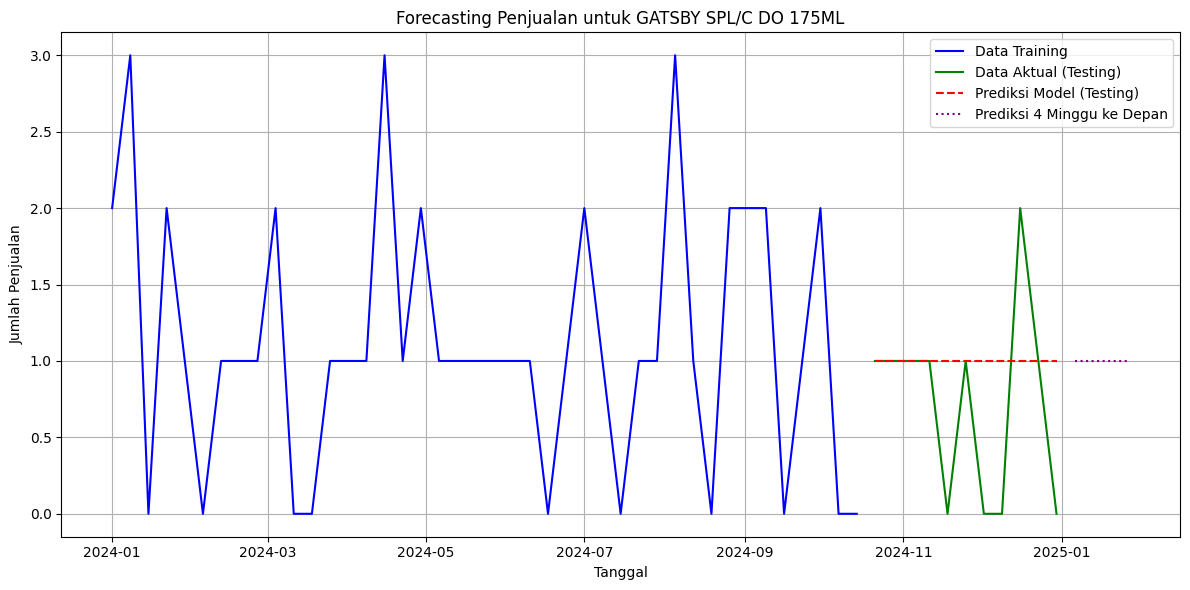



Memproses Item: GATSBY SPL/C GS 175ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk GATSBY SPL/C GS 175ML (periode evaluasi):
            Actual  Predicted
2024-10-21     2.0        0.0
2024-10-28     1.0        0.0
2024-11-04     1.0        0.0
2024-11-11     1.0        0.0
2024-11-18     0.0        0.0
2024-11-25     0.0        0.0
2024-12-02     1.0        0.0
2024-12-09     0.0        0.0
2024-12-16     1.0        0.0
2024-12-23     0.0        0.0
2024-12-30     0.0        0.0

  Evaluasi Model GATSBY SPL/C GS 175ML:
  MAE (Mean Absolute Error): 0.64
  RMSE (Root Mean Squared Error): 0.90
  MAPE (Mean Absolute Percentage Error): 100.00%

  Prediksi Penjualan GATSBY SPL/C GS 175ML untuk 4 minggu ke depan:
2025-01-06    0.0
2025-01-13    0.0
2025-01-20    

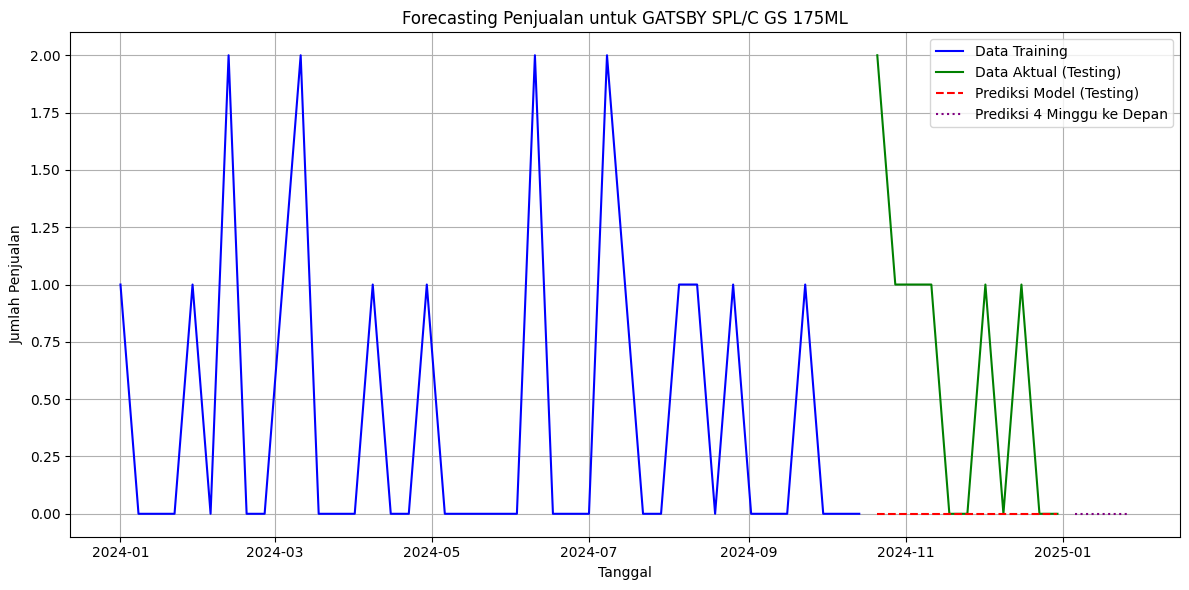



Memproses Item: GREENFIELDS COKLAT 105ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk GREENFIELDS COKLAT 105ML (periode evaluasi):
            Actual  Predicted
2024-10-21     0.0        0.0
2024-10-28     0.0        0.0
2024-11-04     0.0        0.0
2024-11-11     0.0        0.0
2024-11-18    11.0        0.0
2024-11-25     6.0        0.0
2024-12-02     2.0        0.0
2024-12-09     0.0        0.0
2024-12-16     2.0        0.0
2024-12-23     0.0        0.0
2024-12-30     0.0        0.0

  Evaluasi Model GREENFIELDS COKLAT 105ML:
  MAE (Mean Absolute Error): 1.91
  RMSE (Root Mean Squared Error): 3.87
  MAPE (Mean Absolute Percentage Error): 100.00%

  Prediksi Penjualan GREENFIELDS COKLAT 105ML untuk 4 minggu ke depan:
2025-01-06    1.0
2025-01-13    1.0
20

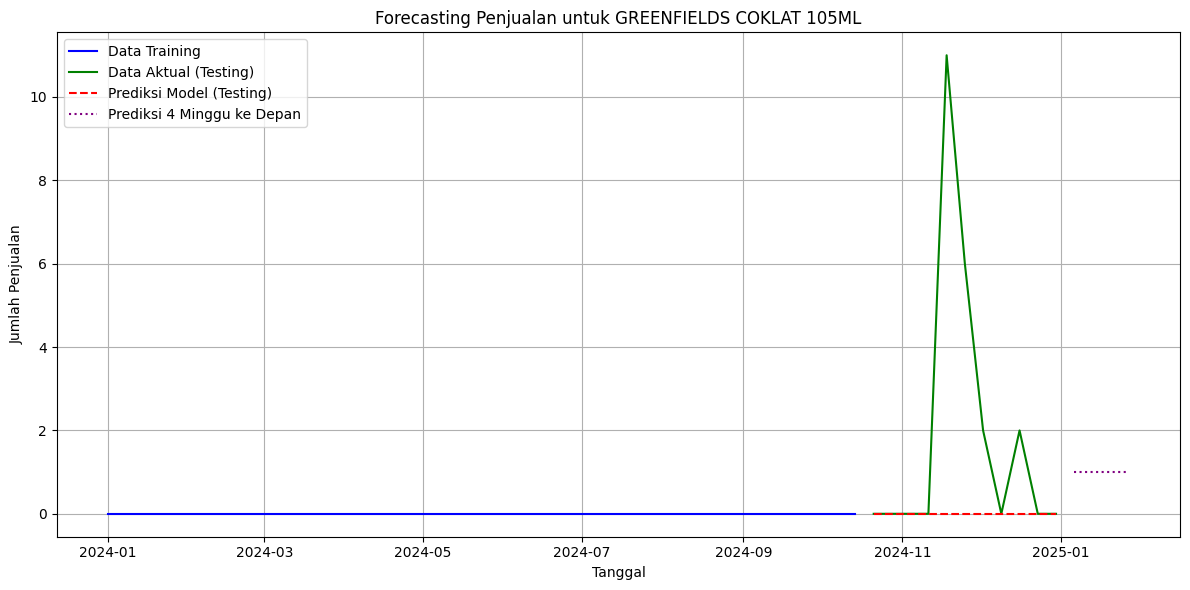



Memproses Item: GREENFIELDS STRAW 105ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk GREENFIELDS STRAW 105ML (periode evaluasi):
            Actual  Predicted
2024-10-21     0.0        0.0
2024-10-28     0.0        0.0
2024-11-04     0.0        0.0
2024-11-11     0.0        0.0
2024-11-18     9.0        0.0
2024-11-25     7.0        0.0
2024-12-02     3.0        0.0
2024-12-09     2.0        0.0
2024-12-16     2.0        0.0
2024-12-23     0.0        0.0
2024-12-30     0.0        0.0

  Evaluasi Model GREENFIELDS STRAW 105ML:
  MAE (Mean Absolute Error): 2.09
  RMSE (Root Mean Squared Error): 3.66
  MAPE (Mean Absolute Percentage Error): 100.00%

  Prediksi Penjualan GREENFIELDS STRAW 105ML untuk 4 minggu ke depan:
2025-01-06    0.0
2025-01-13    0.0
2025-0

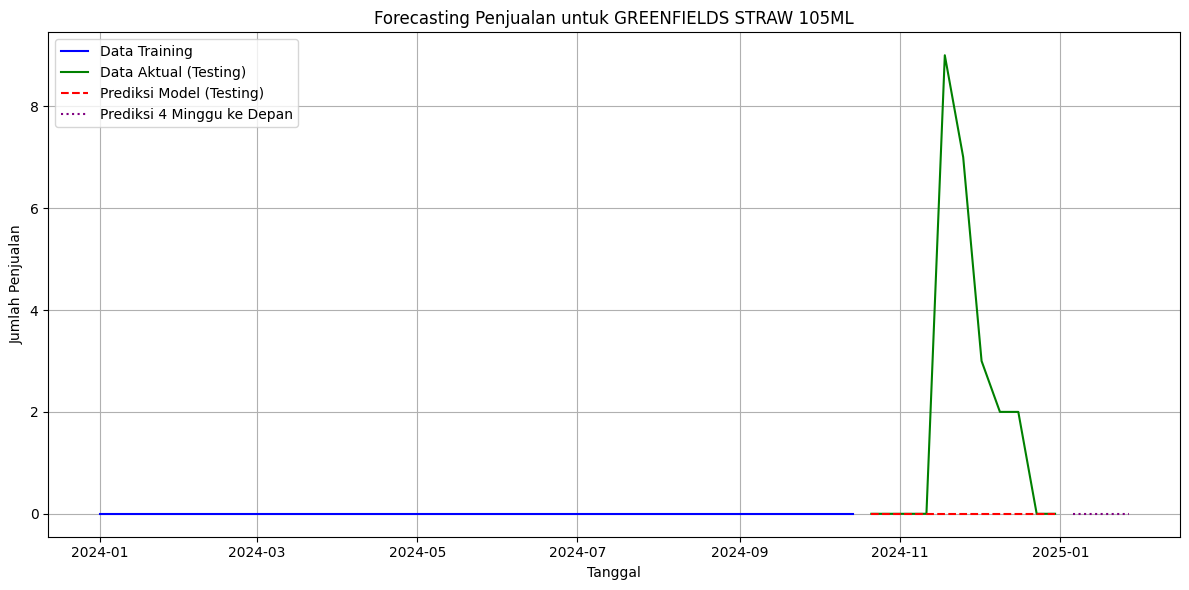



Memproses Item: INDOMILK KID CKL 115ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk INDOMILK KID CKL 115ML (periode evaluasi):
            Actual  Predicted
2024-10-21    49.0       40.0
2024-10-28    48.0       41.0
2024-11-04    51.0       42.0
2024-11-11    33.0       42.0
2024-11-18    44.0       43.0
2024-11-25    33.0       44.0
2024-12-02    47.0       44.0
2024-12-09    46.0       45.0
2024-12-16    66.0       46.0
2024-12-23    60.0       47.0
2024-12-30    21.0       47.0

  Evaluasi Model INDOMILK KID CKL 115ML:
  MAE (Mean Absolute Error): 9.91
  RMSE (Root Mean Squared Error): 12.32
  MAPE (Mean Absolute Percentage Error): 27.07%

  Prediksi Penjualan INDOMILK KID CKL 115ML untuk 4 minggu ke depan:
2025-01-06    49.0
2025-01-13    50.0
2025-01-

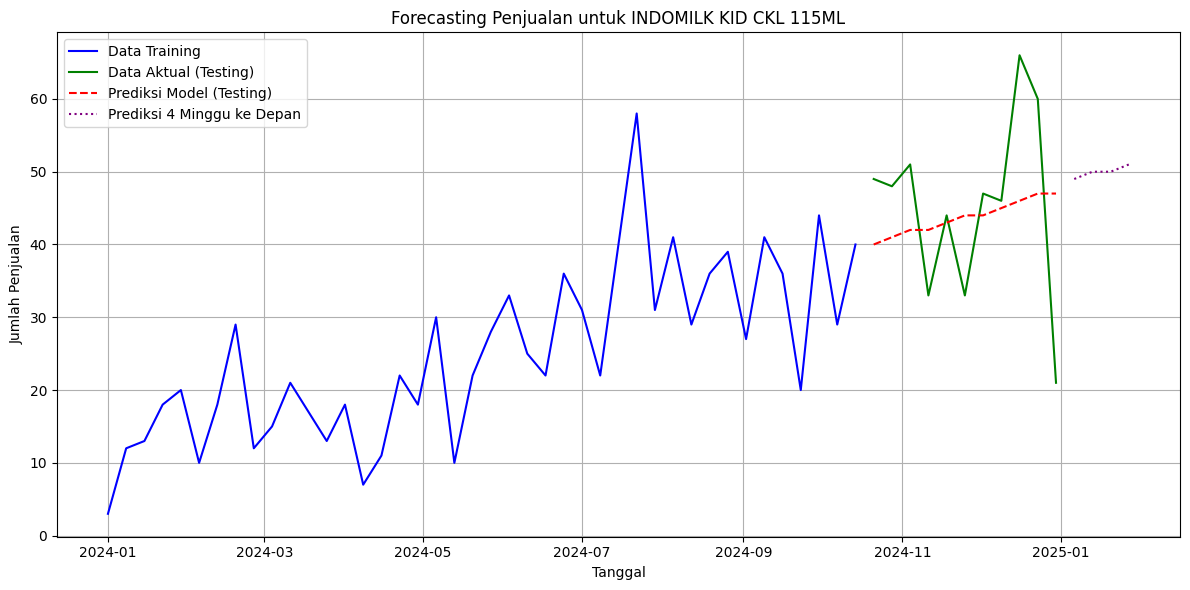



Memproses Item: INDOMILK KID VNL 115ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk INDOMILK KID VNL 115ML (periode evaluasi):
            Actual  Predicted
2024-10-21    17.0       20.0
2024-10-28     8.0       20.0
2024-11-04    15.0       20.0
2024-11-11    15.0       20.0
2024-11-18    15.0       20.0
2024-11-25    18.0       21.0
2024-12-02    11.0       21.0
2024-12-09     6.0       21.0
2024-12-16     3.0       21.0
2024-12-23    10.0       22.0
2024-12-30     6.0       22.0

  Evaluasi Model INDOMILK KID VNL 115ML:
  MAE (Mean Absolute Error): 9.45
  RMSE (Root Mean Squared Error): 10.81
  MAPE (Mean Absolute Percentage Error): 146.54%

  Prediksi Penjualan INDOMILK KID VNL 115ML untuk 4 minggu ke depan:
2025-01-06    7.0
2025-01-13    7.0
2025-01-2

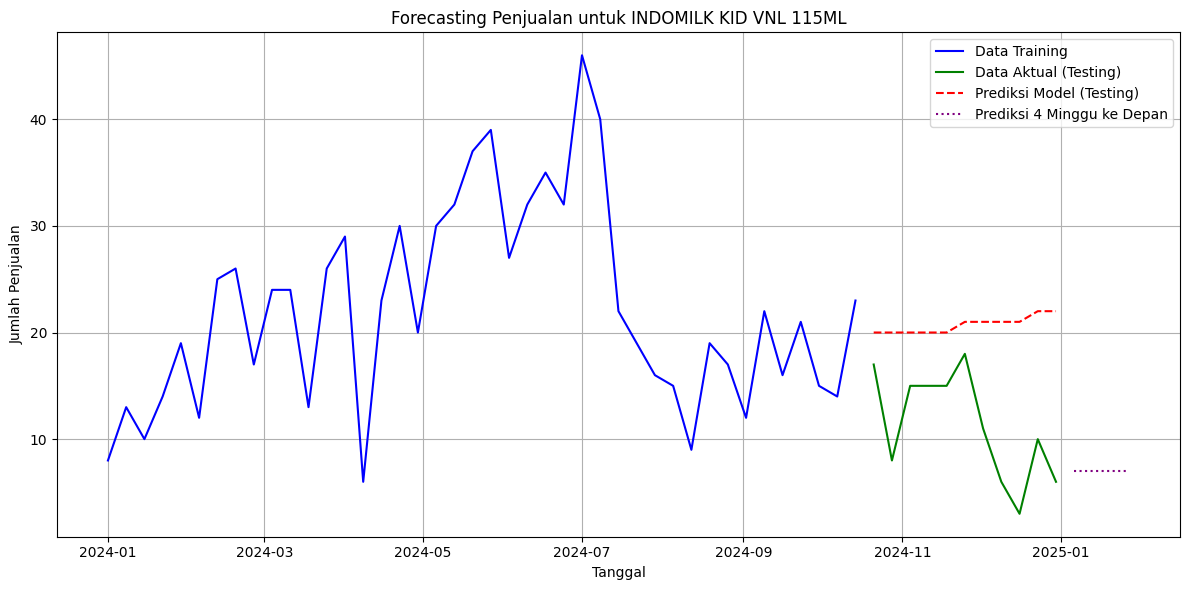



Memproses Item: SAKINAH 1500ML
  Total observasi: 53
  Ukuran data training: 42 observasi (80% dari total)
  Ukuran data testing: 11 observasi (Sisa)
  Data training terakhir: 2024-10-14
  Data testing awal: 2024-10-21
  Model ExponentialSmoothing (Trend='add') berhasil di-fit.

  Prediksi vs Aktual untuk SAKINAH 1500ML (periode evaluasi):
            Actual  Predicted
2024-10-21    56.0       32.0
2024-10-28    47.0       33.0
2024-11-04    39.0       33.0
2024-11-11    49.0       34.0
2024-11-18    44.0       35.0
2024-11-25    37.0       36.0
2024-12-02    23.0       36.0
2024-12-09    31.0       37.0
2024-12-16    31.0       38.0
2024-12-23    15.0       38.0
2024-12-30    11.0       39.0

  Evaluasi Model SAKINAH 1500ML:
  MAE (Mean Absolute Error): 13.27
  RMSE (Root Mean Squared Error): 15.61
  MAPE (Mean Absolute Percentage Error): 58.92%

  Prediksi Penjualan SAKINAH 1500ML untuk 4 minggu ke depan:
2025-01-06    19.0
2025-01-13    19.0
2025-01-20    19.0
2025-01-27    19.0
F

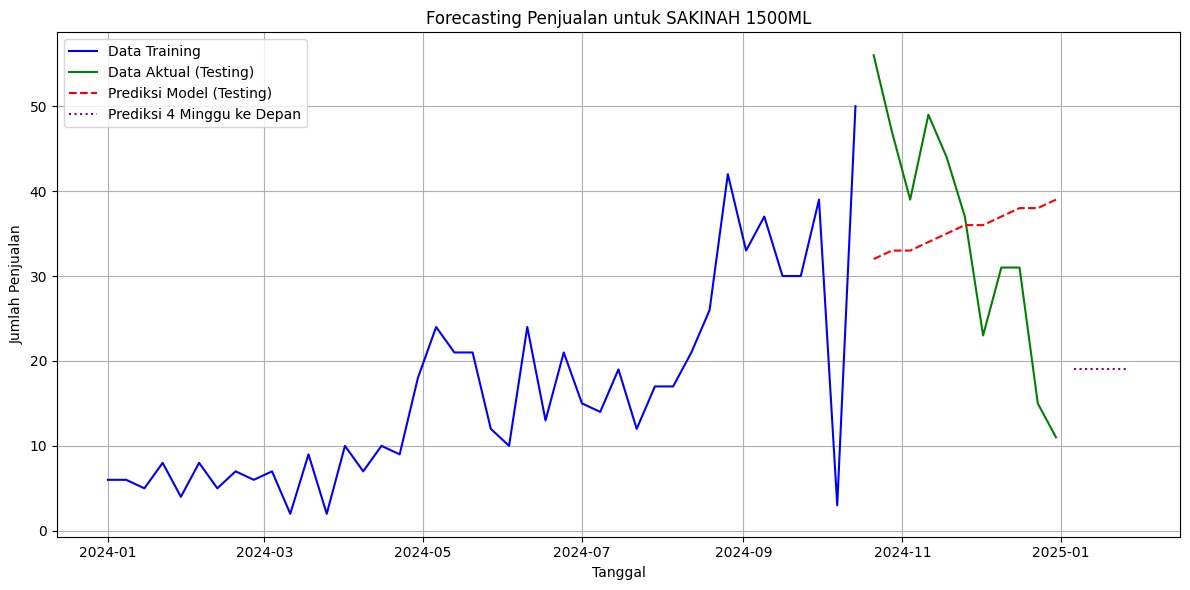

In [ ]:
# --- 3. Looping untuk Setiap Item dan Melakukan Forecasting ---
print("\n--- Memulai Proses Forecasting dan Evaluasi ---\n")

# Menentukan jumlah minimum observasi yang diperlukan
# Untuk model time series sederhana (misal SES), setidaknya 2 data (1 train, 1 test).
# Untuk ExponentialSmoothing dengan trend, idealnya lebih dari itu (misal 3 atau 4).
MIN_OBSERVATIONS_REQUIRED = 3 # Minimal 2 data training, 1 data testing

for item in item_columns:
    print(f"===========================================================")
    print(f"Memproses Item: {item}")
    print(f"===========================================================")

    ts_data = df_pivoted[item].copy()

    # Hitung ukuran train dan test berdasarkan rasio
    total_obs = len(ts_data)
    train_size = int(total_obs * TRAIN_RATIO)
    test_size_dynamic = total_obs - train_size

    # Penanganan kasus data yang sangat sedikit
    # Pastikan minimal ada data untuk training dan testing
    if total_obs < MIN_OBSERVATIONS_REQUIRED:
        print(f"  [SKIPPED] Data terlalu sedikit ({total_obs} observasi) untuk {item}. Minimal {MIN_OBSERVATIONS_REQUIRED} data diperlukan untuk forecasting dan evaluasi.")
        evaluation_results[item] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'Info': 'Not enough data for model fit and split'}
        future_forecasts[item] = np.nan
        continue

    # Sesuaikan ukuran train/test jika hasil perhitungan rasio menghasilkan 0 atau nilai yang terlalu kecil
    if train_size < 1:
        train_size = 1 # Minimal 1 data untuk training
    if test_size_dynamic < 1:
        test_size_dynamic = 1 # Minimal 1 data untuk testing

    # Jika setelah penyesuaian, total data menjadi kurang dari yang dibutuhkan (misal karena penyesuaian train_size & test_size)
    if train_size + test_size_dynamic > total_obs:
        # Ini bisa terjadi jika total_obs sangat kecil dan kita forced train_size/test_size ke 1
        # Dalam kasus ini, kita bisa alokasikan sisanya ke train, atau ulang alokasi
        # Untuk kesederhanaan, jika total_obs sangat kecil dan train_size sudah 1, sisanya ke test_size_dynamic
        test_size_dynamic = total_obs - train_size
        if test_size_dynamic < 1: # Kalau masih 0, berarti data terlalu sedikit
            print(f"  [SKIPPED] Data terlalu sedikit ({total_obs} observasi) untuk {item} setelah penyesuaian rasio. Tidak bisa membuat train/test set yang valid.")
            evaluation_results[item] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'Info': 'Not enough data for valid split'}
            future_forecasts[item] = np.nan
            continue

    # Memisahkan data training dan testing secara kronologis (data terakhir untuk testing)
    train_data = ts_data[:-test_size_dynamic]
    test_data = ts_data[-test_size_dynamic:]

    # Pastikan data training tidak kosong (bisa terjadi jika total_obs sangat kecil dan test_size_dynamic mengambil semua)
    if len(train_data) == 0:
        print(f"  [SKIPPED] Data training kosong untuk {item} setelah split. Total data: {total_obs}, Train size: {train_size}, Test size: {test_size_dynamic}.")
        evaluation_results[item] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'Info': 'Training data is empty after split'}
        future_forecasts[item] = np.nan
        continue


    print(f"  Total observasi: {total_obs}")
    print(f"  Ukuran data training: {len(train_data)} observasi ({TRAIN_RATIO*100:.0f}% dari total)")
    print(f"  Ukuran data testing: {len(test_data)} observasi (Sisa)")
    print(f"  Data training terakhir: {train_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  Data testing awal: {test_data.index[0].strftime('%Y-%m-%d')}")

    # --- Pemilihan Model (Exponential Smoothing) ---
    try:
        model = ExponentialSmoothing(train_data,
                                     trend='add',
                                     seasonal=None,
                                     initialization_method="estimated"
                                    )
        model_fit = model.fit()
        print(f"  Model ExponentialSmoothing (Trend='add') berhasil di-fit.")
    except Exception as e:
        print(f"  Gagal fit model ExponentialSmoothing (Trend='add') untuk {item}: {e}. Mencoba SimpleExpSmoothing.")
        # Fallback ke SimpleExpSmoothing jika model yang lebih kompleks gagal
        try:
            model = SimpleExpSmoothing(train_data, initialization_method="estimated")
            model_fit = model.fit()
            print(f"  Menggunakan SimpleExpSmoothing untuk {item}.")
        except Exception as e_simple:
            print(f"  Gagal fit SimpleExpSmoothing untuk {item}: {e_simple}. Melewatkan item ini.")
            evaluation_results[item] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'Info': f'Model fit failed: {e_simple}'}
            future_forecasts[item] = np.nan
            continue


    # --- Evaluasi Model ---
    # Membuat prediksi untuk periode test
    predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    # Pastikan prediksi tidak negatif dan bulatkan ke integer
    predictions = np.maximum(0, predictions).round()

    print(f"\n  Prediksi vs Aktual untuk {item} (periode evaluasi):")
    eval_df = pd.DataFrame({'Actual': test_data, 'Predicted': predictions})
    print(eval_df)

    # Menghitung Metrik Evaluasi
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mape = mean_absolute_percentage_error(test_data, predictions)

    evaluation_results[item] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    print(f"\n  Evaluasi Model {item}:")
    print(f"  MAE (Mean Absolute Error): {mae:.2f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.2f}")
    if not np.isnan(mape):
        print(f"  MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    else:
        print(f"  MAPE: Tidak dapat dihitung (tidak ada nilai aktual > 0 dalam periode testing).")

    # --- Forecasting Masa Depan ---
    # Memprediksi untuk N minggu ke depan dari data TERAKHIR (termasuk data test)
    # Kita akan fit ulang model dengan data LENGKAP untuk prediksi masa depan yang paling akurat
    try:
        final_model = ExponentialSmoothing(ts_data, # Menggunakan seluruh data ts_data
                                        trend='add',
                                        seasonal=None,
                                        initialization_method="estimated"
                                       )
        final_model_fit = final_model.fit()
    except Exception:
        # Fallback jika model dengan tren gagal pada data lengkap
        final_model = SimpleExpSmoothing(ts_data, initialization_method="estimated")
        final_model_fit = final_model.fit()

    future_predictions = final_model_fit.predict(start=df_pivoted.index[-1] + pd.Timedelta(weeks=1),
                                                 end=df_pivoted.index[-1] + pd.Timedelta(weeks=FORECAST_HORIZON))

    # Pastikan prediksi tidak negatif dan bulatkan ke integer
    future_predictions = np.maximum(0, future_predictions).round()

    print(f"\n  Prediksi Penjualan {item} untuk {FORECAST_HORIZON} minggu ke depan:")
    print(future_predictions.to_string())

    # Simpan hasil prediksi ke DataFrame future_forecasts
    future_forecasts[item] = future_predictions.values

    # --- Visualisasi (Opsional) ---
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Data Training', color='blue')
    plt.plot(test_data.index, test_data, label='Data Aktual (Testing)', color='green')
    plt.plot(predictions.index, predictions, label='Prediksi Model (Testing)', color='red', linestyle='--')
    plt.plot(future_predictions.index, future_predictions, label=f'Prediksi {FORECAST_HORIZON} Minggu ke Depan', color='purple', linestyle=':')
    plt.title(f'Forecasting Penjualan untuk {item}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Penjualan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n")

In [17]:
# --- 4. Ringkasan Hasil Evaluasi dan Prediksi ---
print("\n--- Ringkasan Hasil Evaluasi Model ---")
eval_df_summary = pd.DataFrame.from_dict(evaluation_results, orient='index')
print(eval_df_summary)

print("\n--- Prediksi Penjualan untuk {} Minggu Ke Depan ---".format(FORECAST_HORIZON))
print(future_forecasts.to_string())


--- Ringkasan Hasil Evaluasi Model ---
                                MAE       RMSE        MAPE
BISKUAT BOLU CKL 16GR      2.454545   3.450955   30.875458
CLOUD 9 CHOCO 15 4G        3.909091   5.178627   59.433831
CLOUD 9 VANILA 15 4G       3.090909   3.567530   64.069264
FRESHCARE ORIGINAL 10ML    1.000000   1.087115   44.444444
GATSBY SPL/C DO 175ML      0.454545   0.674200    7.142857
GATSBY SPL/C GS 175ML      0.636364   0.904534  100.000000
GREENFIELDS COKLAT 105ML   1.909091   3.872983  100.000000
GREENFIELDS STRAW 105ML    2.090909   3.655631  100.000000
INDOMILK KID CKL 115ML     9.909091  12.317762   27.073876
INDOMILK KID VNL 115ML     9.454545  10.812451  146.535408
SAKINAH 1500ML            13.272727  15.614678   58.921318

--- Prediksi Penjualan untuk 4 Minggu Ke Depan ---
            BISKUAT BOLU CKL 16GR  CLOUD 9 CHOCO 15 4G  CLOUD 9 VANILA 15 4G  FRESHCARE ORIGINAL 10ML  GATSBY SPL/C DO 175ML  GATSBY SPL/C GS 175ML  GREENFIELDS COKLAT 105ML  GREENFIELDS STRAW 105ML  